"""
📘 Portfolio Project: Catalonia Water Resource Monitoring — Time Series & Spatial Analysis

Author: YI LUO  
Date: 2025-03-22  
Data Source: https://www.kaggle.com/datasets/edomingo/catalonia-water-resource-daily-monitoring/data

---

🧠 Project Overview:
This notebook presents a complete data science workflow applied to public water sensor data from Catalonia.
It demonstrates exploratory analysis, time series modeling, anomaly detection, and spatial visualization
— showcasing skills in data cleaning, temporal and geospatial analytics, and visual storytelling.

---

🔍 What We Did:

1. ✅ **Data Loading & Cleaning**
   - Parsed and combined time series sensor readings with geolocation metadata.
   - Converted timestamps, removed noisy columns, and handled missing values.

2. 📊 **Data Quality Inspection**
   - Computed missing value ratio per sensor.
   - Identified top sensors with the most complete data.

3. 📈 **Time Series Visualization**
   - Plotted raw readings of top-performing sensors (filtered by unit).
   - Provided both full-scale and zoomed-in views to highlight trends and anomalies.

4. 🔁 **Seasonal Decomposition**
   - Used additive models to separate each sensor's trend, seasonal, and residual components.

5. ⚠️ **Anomaly Detection**
   - Applied statistical thresholding (mean + 3×std) to detect unusual spikes.
   - Visualized anomalies both in grouped and individual subplots.

6. 🗺️ **Geospatial Mapping**
   - Created interactive Folium maps showing:
     - Sensor location and anomaly count
     - Missing data coverage across the region

7. 🔮 **Forecasting (Exploratory)**
   - Built ARIMA models for selected clean sensors.
   - Forecasted short-term trends over the next 48 time points (2 days).

---

📌 Key Findings:
- A few sensors consistently show abnormally high readings — potential outliers or real flood events.
- Some areas in the map reveal low sensor coverage or high data loss (>40% missing).
- Temporal trends suggest weekly or seasonal patterns in discharge behavior.

This project demonstrates applied data science skills for environmental monitoring, with tools like
Pandas, Matplotlib, Statsmodels, GeoPandas, Contextily, and Folium.

"""

In [1]:
# SECTION 1 — Import Libraries & Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Geospatial & visualization
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import folium
from folium.plugins import MarkerCluster

# Time series tools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings to keep output clean for portfolio
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)



# Load data (adjust paths for local testing)
data_file = Path("/Users/luoyi/Desktop/10_kaggle/04_Water_Resource/gauge_sensors_reads.csv")
meta_file = Path("/Users/luoyi/Desktop/10_kaggle/04_Water_Resource/metadata/gauge_sensors_metadata.csv")

# Load time series data
df = pd.read_csv(data_file)
df.rename(columns={"Unnamed: 0": "timestamp"}, inplace=True)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

# Load sensor metadata
df_meta = pd.read_csv(meta_file)

# Preview
print("✅ Data loaded:")
print(f"→ Sensor readings shape: {df.shape}")
print("→ Metadata preview:")
display(df_meta[["sensor_id", "description", "unit"]].head())

✅ Data loaded:
→ Sensor readings shape: (3156, 177)
→ Metadata preview:


,sensor_id,description,unit
0,080060-001-ANA01,River level,cm
1,080180-005-ANA001,Canal discharge,l/s
2,080180-005-ANA002,Canal discharge,l/s
3,081252-001-ANA02,River level,cm
4,171501-001-ANA001,River level,cm


In [2]:
# SECTION 2 — Data Quality Overview

# 1. Check missing value ratio for each sensor
missing_ratio = df.isnull().mean().sort_values()

# 2. View basic statistics
print("✅ Missing value ratio (top 10 sensors with best data):")
display(missing_ratio.head(10))

# 3. Join missing ratio into metadata for mapping and filtering
df_meta["missing_ratio"] = df_meta["sensor_id"].map(missing_ratio)

# 4. Preview sensors grouped by data coverage
print("\n📊 Sensor coverage breakdown:")
print(df_meta["missing_ratio"].describe())

# 5. Create a list of sensors with good data coverage (< 20% missing)
good_sensors = missing_ratio[missing_ratio < 0.2].index.tolist()
print(f"\n✅ Number of usable sensors (< 20% missing): {len(good_sensors)}")

✅ Missing value ratio (top 10 sensors with best data):


080996-007-ANA010    0.0
CALC001219           0.0
CALC001218           0.0
082021-001-ANA002    0.0
CALC001212           0.0
080885-001-ANA001    0.0
CALC001210           0.0
081445-001-ANA002    0.0
CALC001209           0.0
CALC001204           0.0
dtype: float64


📊 Sensor coverage breakdown:
count    171.000000
mean       0.052804
std        0.141427
min        0.000000
25%        0.000000
50%        0.001901
75%        0.024081
max        1.000000
Name: missing_ratio, dtype: float64

✅ Number of usable sensors (< 20% missing): 152


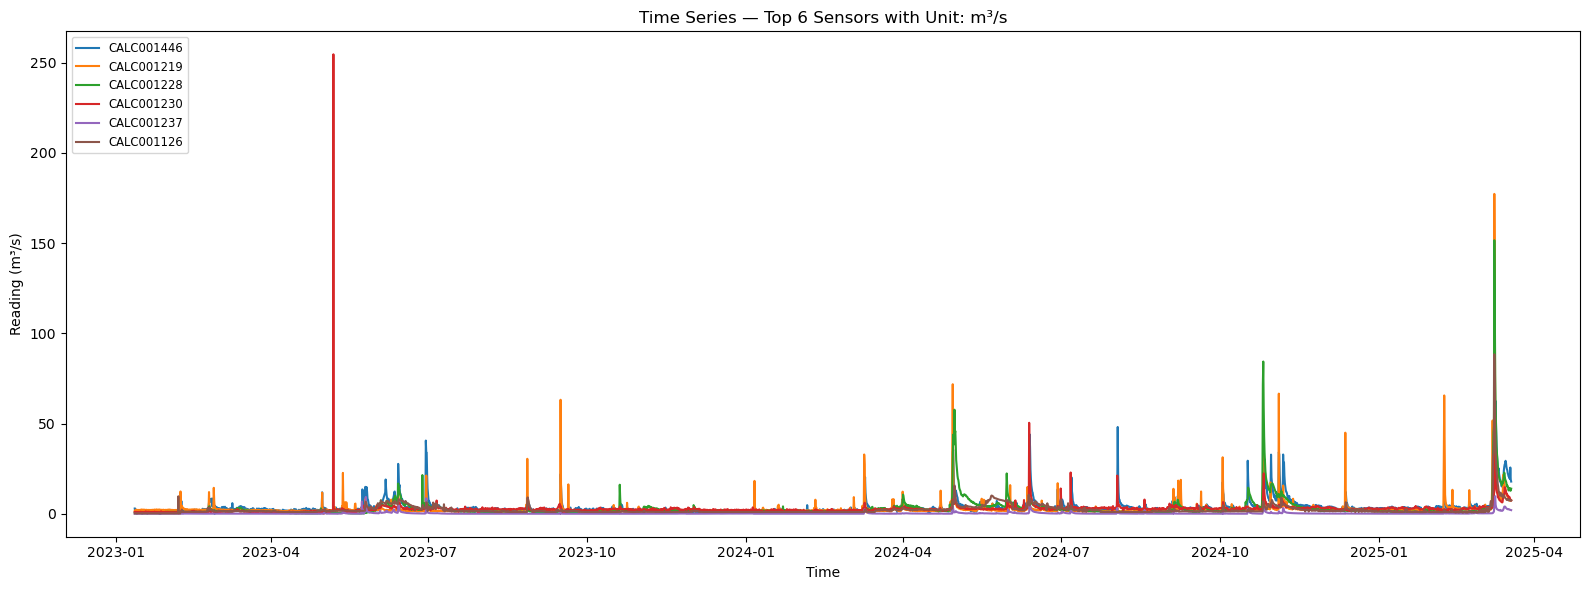

In [3]:
# SECTION 3 — Visualize Time Series of Top 6 Sensors (Same Unit Only)

# Step 1: Choose a unit to focus on (e.g., 'm³/s' for flow or 'cm' for height)
unit_filter = "m³/s"  # Change this to 'cm' or another unit from df_meta['unit'].unique()

# Step 2: Filter metadata for sensors using the selected unit and good data coverage
top_sensors_same_unit = (
    df_meta[(df_meta["unit"] == unit_filter) & (df_meta["missing_ratio"] < 0.2)]
    .sort_values("missing_ratio")
    .head(6)
)

selected_sensors = top_sensors_same_unit["sensor_id"].tolist()

# Step 3: Plot the selected sensors
plt.figure(figsize=(16, 6))

for sensor in selected_sensors:
    plt.plot(df[sensor].sort_index(), label=f"{sensor}")

plt.title(f"Time Series — Top 6 Sensors with Unit: {unit_filter}")
plt.xlabel("Time")
plt.ylabel(f"Reading ({unit_filter})")
plt.legend(loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()

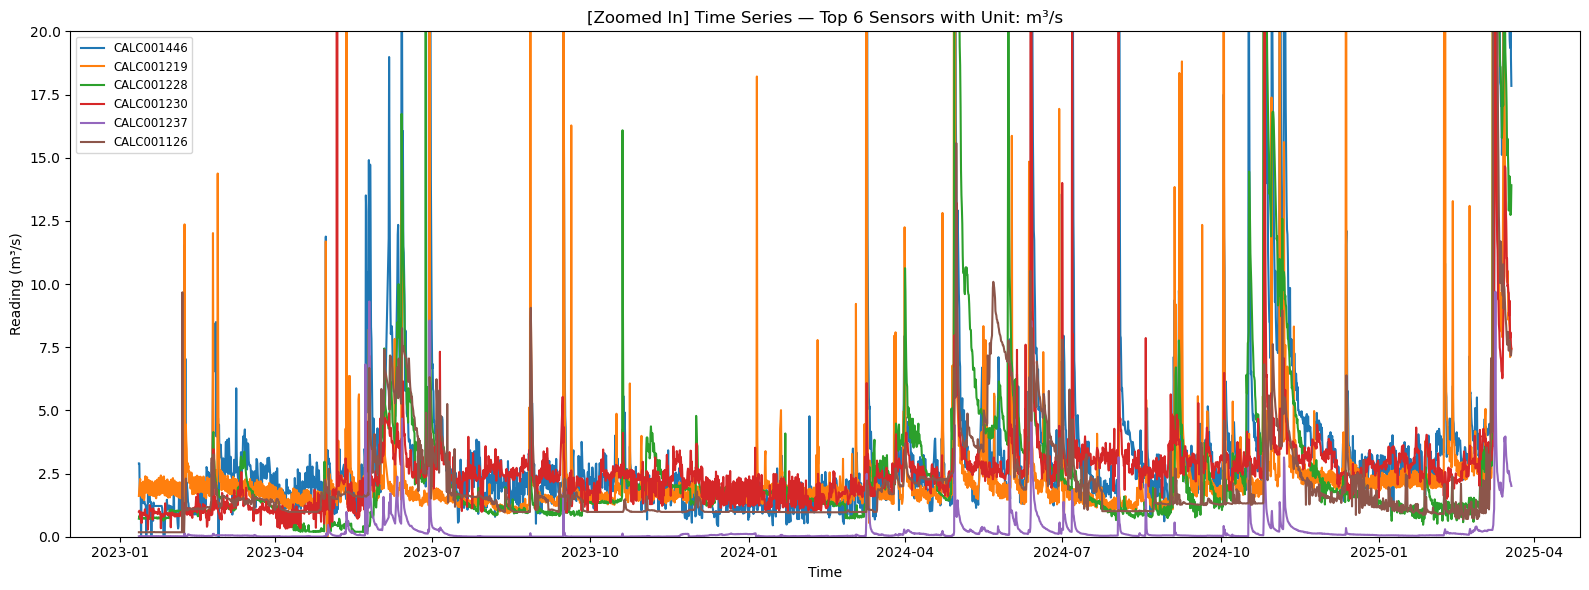

In [4]:
# Plot (2): Zoom in by capping y-axis to improve trend visibility
plt.figure(figsize=(16, 6))

for sensor in selected_sensors:
    series = df[sensor].sort_index()
    plt.plot(series, label=sensor)

plt.ylim(0, 20)  # Cap y-axis (tune this as needed based on your typical value range)

plt.title(f"[Zoomed In] Time Series — Top 6 Sensors with Unit: {unit_filter}")
plt.xlabel("Time")
plt.ylabel(f"Reading ({unit_filter})")
plt.legend(loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()

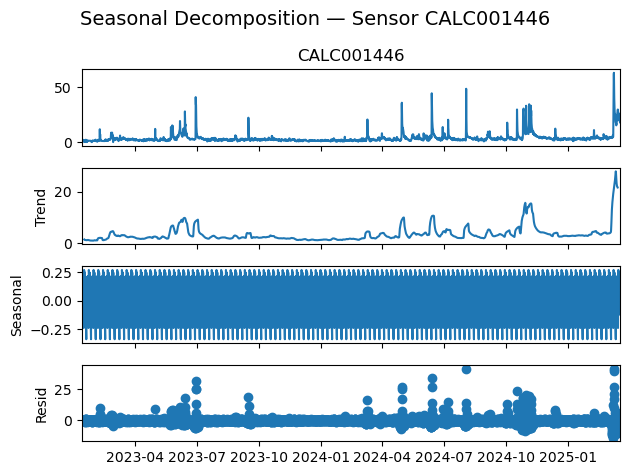

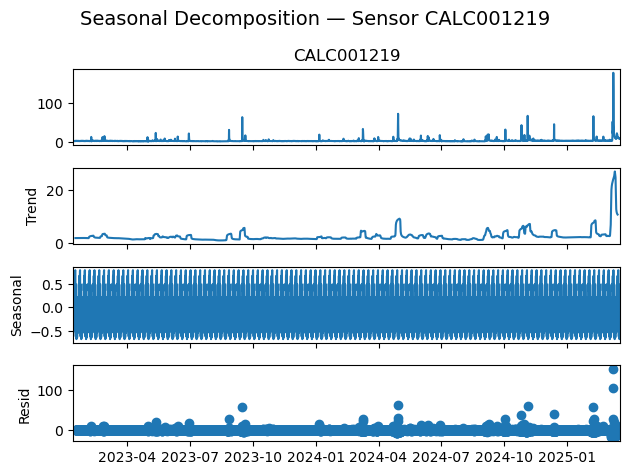

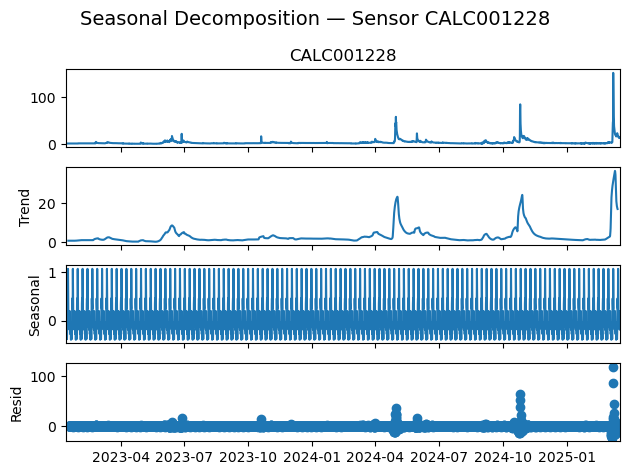

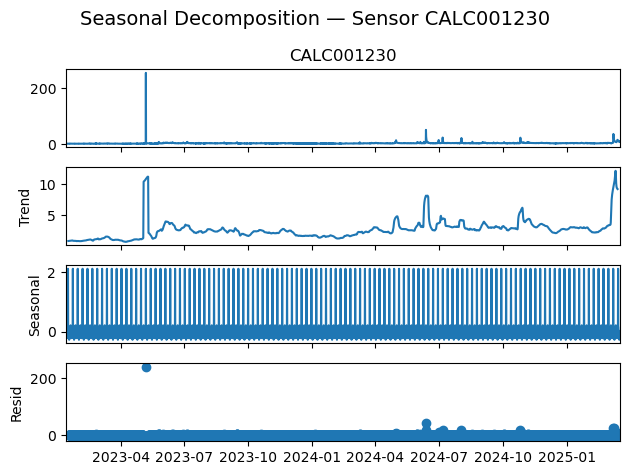

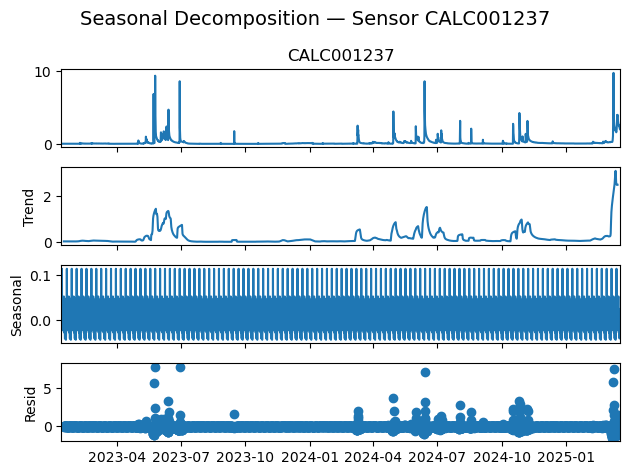

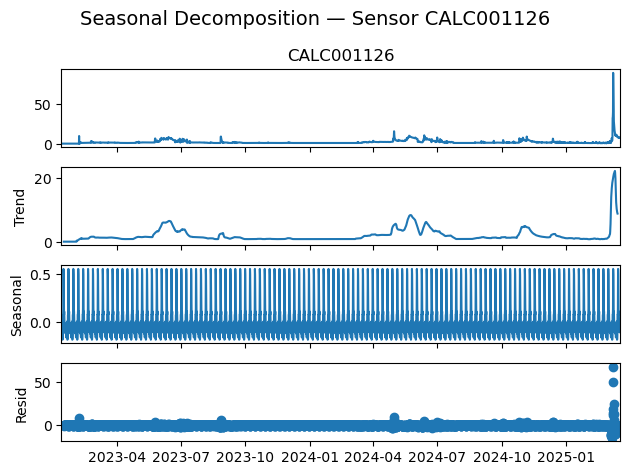

In [5]:
# SECTION 4 — Decompose Time Series into Trend, Seasonality, and Residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 1: Set frequency and interpolation for regularity
# 6-hour intervals → 4 per day × 7 days = 28 points per week
decomposition_period = 28

# Loop through the selected sensors
for sensor in selected_sensors:
    # Clean and regularize the series
    series = df[sensor].sort_index().asfreq("6H").interpolate(method="time")
    
    # Skip if still contains NaNs
    if series.isnull().any():
        print(f"⛔ Skipping {sensor} due to NaNs")
        continue

    try:
        # Decompose the time series
        result = seasonal_decompose(series, model="additive", period=decomposition_period)

        # Plot result
        result.plot()
        plt.suptitle(f"Seasonal Decomposition — Sensor {sensor}", fontsize=14)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Skipped sensor {sensor}: {e}")

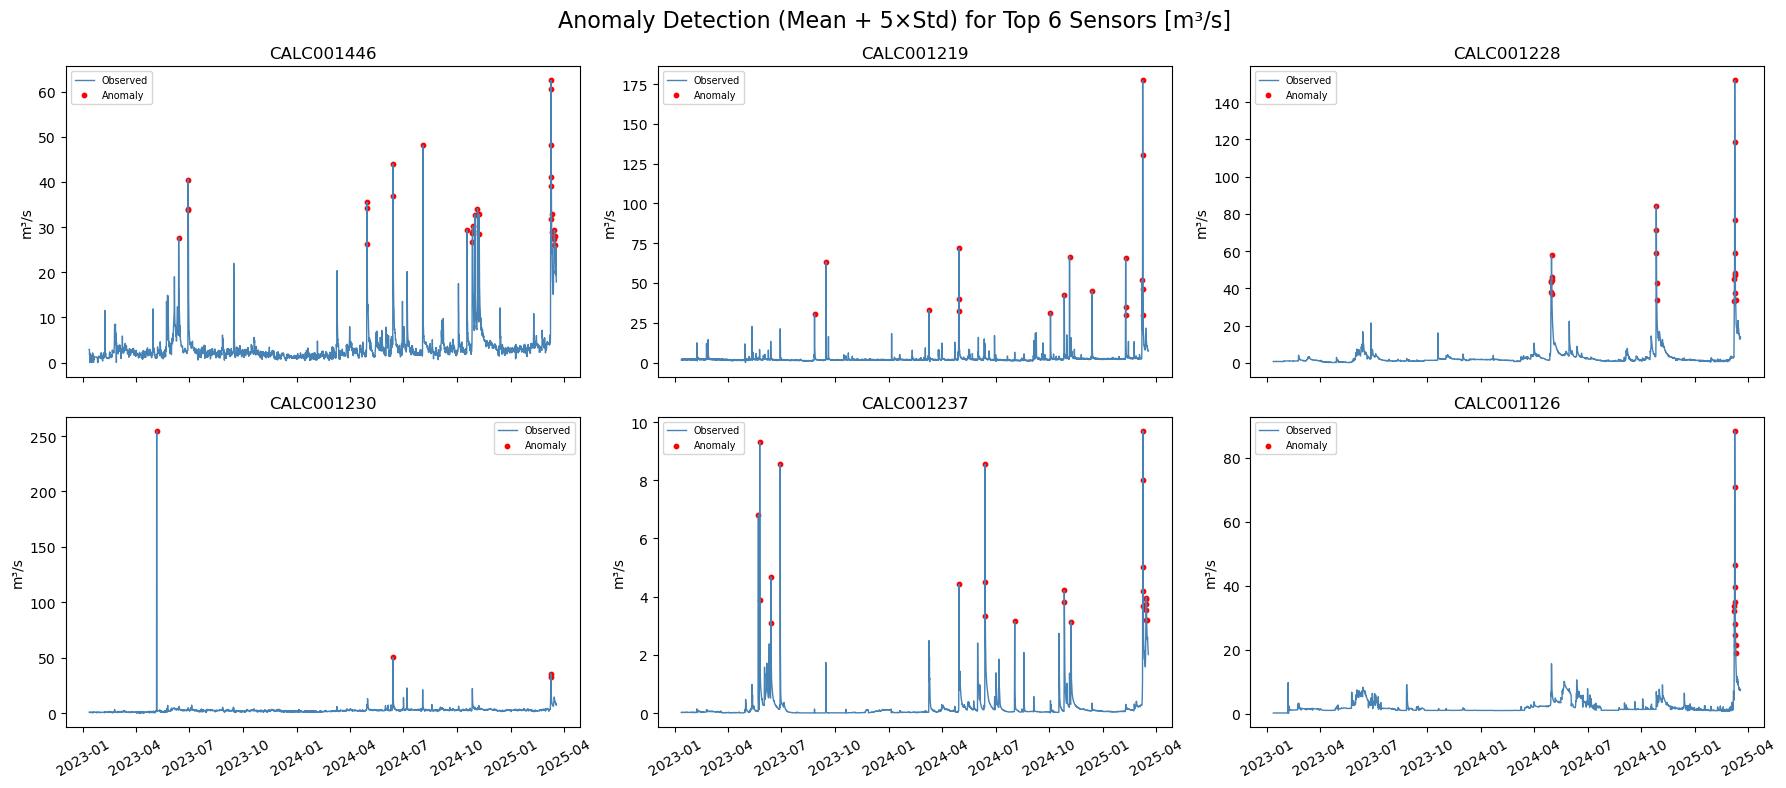

In [6]:
# SECTION 5 — Anomaly Detection with Subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharex=True)
axs = axs.flatten()

for i, sensor in enumerate(selected_sensors):
    series = df[sensor].sort_index().asfreq("6H").interpolate(method="time")
    threshold = series.mean() + 5 * series.std()
    anomalies = series[series > threshold]

    axs[i].plot(series, label="Observed", color="steelblue", linewidth=1)
    axs[i].scatter(anomalies.index, anomalies, color="red", s=10, label="Anomaly")
    
    axs[i].set_title(sensor)
    axs[i].set_ylabel(unit_filter)
    axs[i].legend(fontsize="x-small")
    axs[i].tick_params(axis='x', labelrotation=30)

fig.suptitle(f"Anomaly Detection (Mean + 5×Std) for Top 6 Sensors [{unit_filter}]", fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
# SECTION 6 — Interactive Map of Sensors and Their Anomaly Counts (No Clustering)
import folium
from IPython.display import IFrame

# STEP 1 — Refined anomaly detection (mean + 5×std, at least 5 points)
anomaly_counts = {
    sensor: (df[sensor] > df[sensor].mean() + 5 * df[sensor].std()).sum()
    for sensor in df.columns if sensor in df_meta["sensor_id"].values
}

df_meta["anomaly_count"] = df_meta["sensor_id"].map(anomaly_counts).fillna(0).astype(int)
df_meta["is_anomalous"] = df_meta["anomaly_count"] > 5

# STEP 2 — Parse coordinates from 'location' field
df_meta["lat"] = df_meta["location"].apply(lambda x: float(str(x).split()[0]))
df_meta["lon"] = df_meta["location"].apply(lambda x: float(str(x).split()[1]))

# STEP 3 — Initialize the folium map
map_center = [df_meta["lat"].mean(), df_meta["lon"].mean()]
m = folium.Map(location=map_center, zoom_start=8, tiles="OpenStreetMap")

# STEP 4 — Add markers one by one with red or green color
for _, row in df_meta.iterrows():
    popup_html = f"""
    <b>Sensor:</b> {row['sensor_id']}<br>
    <b>Description:</b> {row['description']}<br>
    <b>Missing:</b> {row['missing_ratio']:.1%}<br>
    <b>Anomaly Count:</b> {row['anomaly_count']}
    """

    color = "red" if row["is_anomalous"] else "green"

    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=6,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# STEP 5 — Save to file and embed in notebook
m.save("20250322_Catalonia_Water_Resource_Gauge_Sensor_anomaly_map.html")
IFrame("20250322_Catalonia_Water_Resource_Gauge_Sensor_anomaly_map.html", width=1200, height=800)

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Step 1 — Select 3 clean sensors for forecasting
forecast_sensors = df_meta[
    (df_meta["unit"] == unit_filter) & 
    (df_meta["missing_ratio"] < 0.2)
].sort_values("missing_ratio").head(3)["sensor_id"].tolist()

forecast_steps = 48  # 6-hour interval → next 2 days
forecast_dict = {}

for sensor in forecast_sensors:
    series = df[sensor].sort_index().asfreq("6H").interpolate(method="time")

    try:
        model = ARIMA(series, order=(1, 1, 1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=forecast_steps)

        forecast_index = pd.date_range(
            start=series.index[-1] + pd.Timedelta("6H"),
            periods=forecast_steps,
            freq="6H"
        )

        forecast_dict[sensor] = {
            "observed": series[-100:],  # last 100 observed values
            "forecast": pd.Series(forecast.values, index=forecast_index)
        }

    except Exception as e:
        print(f"⚠️ Forecast failed for sensor {sensor}: {e}")

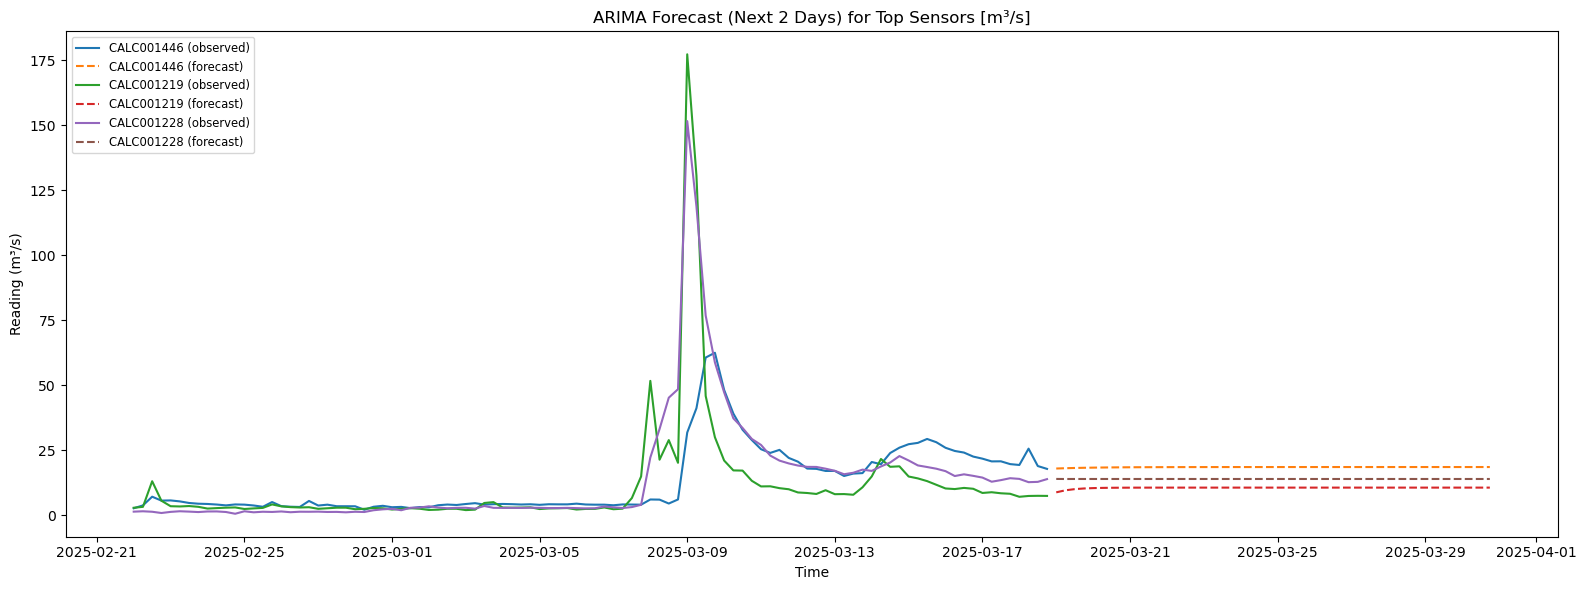

In [9]:
# Step 2 — Visualize Observed + Forecast for Each Sensor
plt.figure(figsize=(16, 6))

for sensor, data in forecast_dict.items():
    plt.plot(data["observed"], label=f"{sensor} (observed)")
    plt.plot(data["forecast"], linestyle="--", label=f"{sensor} (forecast)")

plt.title(f"ARIMA Forecast (Next 2 Days) for Top Sensors [{unit_filter}]")
plt.xlabel("Time")
plt.ylabel(f"Reading ({unit_filter})")
plt.legend(loc="upper left", fontsize="small")
plt.tight_layout()
plt.show()

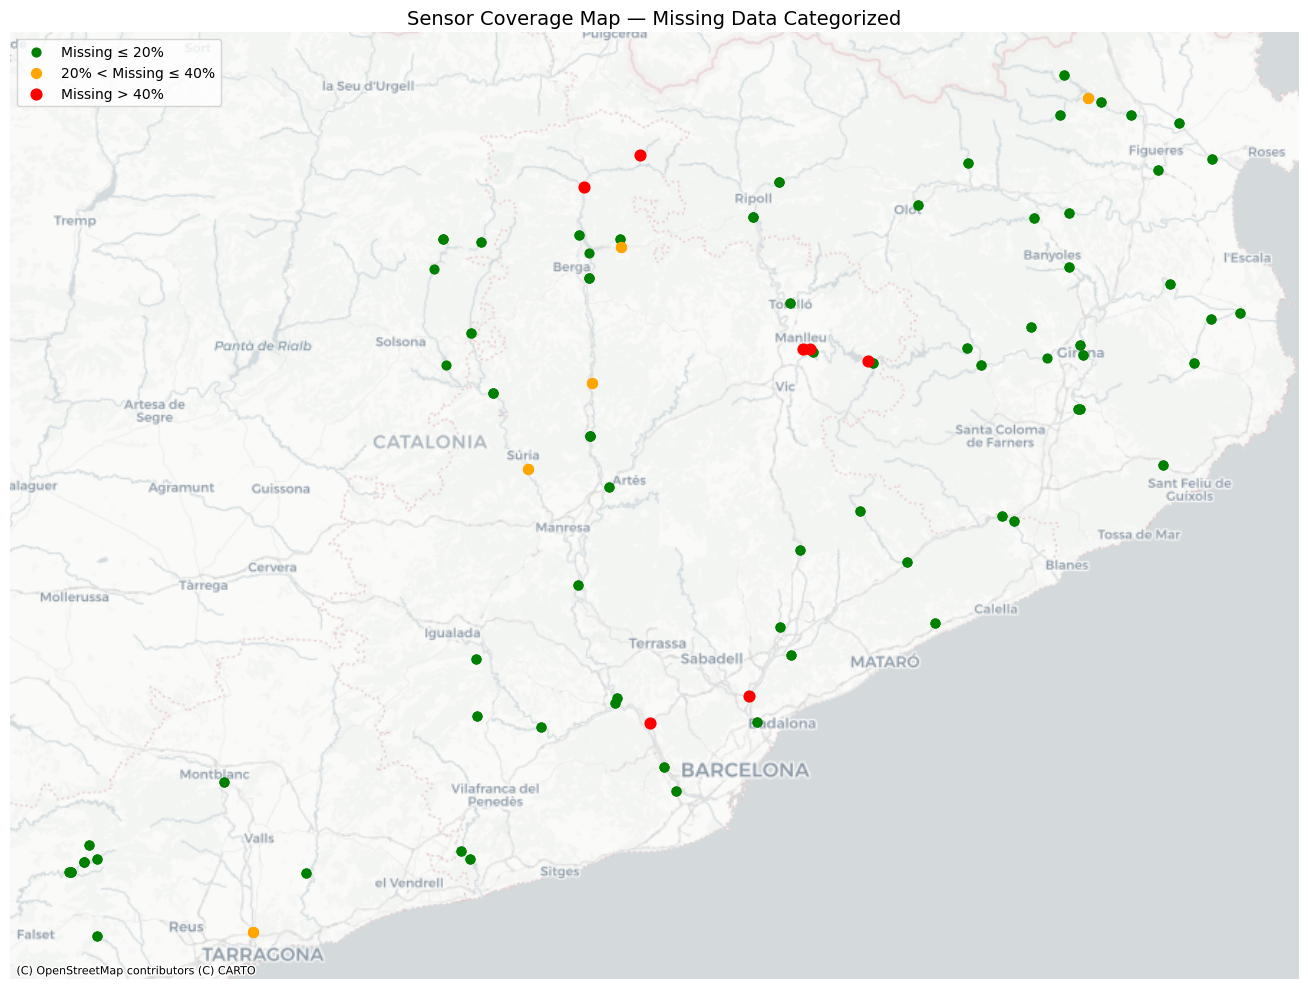

In [10]:
# SECTION 8 — Geospatial Visualization of Missing Data per Sensor
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt

# Step 1: Ensure missing_ratio is available
missing_ratio = df.isnull().mean()
df_meta["missing_ratio"] = df_meta["sensor_id"].map(missing_ratio)

# Step 2: Extract coordinates from metadata
df_meta["lat"] = df_meta["location"].apply(lambda x: float(str(x).split()[0]))
df_meta["lon"] = df_meta["location"].apply(lambda x: float(str(x).split()[1]))

# Step 3: Create GeoDataFrame and reproject
geometry = [Point(xy) for xy in zip(df_meta["lon"], df_meta["lat"])]
gdf = gpd.GeoDataFrame(df_meta, geometry=geometry, crs="EPSG:4326")
gdf_web = gdf.to_crs(epsg=3857)

# Step 4: Plot by missing ratio category
fig, ax = plt.subplots(figsize=(14, 10))

gdf_web[gdf_web["missing_ratio"] <= 0.2].plot(
    ax=ax, color="green", markersize=40, label="Missing ≤ 20%")

gdf_web[(gdf_web["missing_ratio"] > 0.2) & (gdf_web["missing_ratio"] <= 0.4)].plot(
    ax=ax, color="orange", markersize=50, label="20% < Missing ≤ 40%")

gdf_web[gdf_web["missing_ratio"] > 0.4].plot(
    ax=ax, color="red", markersize=60, label="Missing > 40%")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("Sensor Coverage Map — Missing Data Categorized", fontsize=14)
ax.set_axis_off()
ax.legend()
plt.tight_layout()
plt.show()